# Exercício: *Fine-tuning* do Modelo de Linguagem com auto-atenção utilizando LoRA

**Nome:** Caio Petrucci dos Santos Rosa

**RA:** 248245

# Bibliotecas e pacotes

In [ ]:
import os
import random
import re
import string
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
# Essa flag deve ser utilizada para facilitar a detecção de erros durante a implementação do modelo
# Definir como False sempre e como True apenas para debugging
torch.autograd.set_detect_anomaly(False)

# Hiper-parâmetros

In [ ]:
# Tamanho do vocabulario
#   Influencia o pre-processamento de dados e a arquitetura do modelo
vocab_size = 3000


# ID do token desconhecido
#   Influencia o pre-processamento de dados
unknown_token_id = -1


# Tokens reservados
#   Influencia o pre-processamento de dados
n_reserved_tokens = 2
first_token_id = n_reserved_tokens
sos_token_id = 0
eos_token_id = 1


# Tamanho do contexto
#   Influencia a construcao do dataset e a arquitetura do modelo
context_size = 9


# Parametros de arquitetura do modelo
n_heads = 1
d_model = 64
d_ff = 4 * d_model
p_dropout = 0.10
lora_rank = 8
lora_alpha = 16


# Parametros de treinamento do modelo
batch_size = 64
warmup_ratio = 0.20

pretrain_epochs = 5
lora_epochs = 10

lr = 5e-3
weight_decay = 2e-4
betas = (0.99, 0.98)
eps = 1e-8

Os parâmetros associados ao otimizador Adam não foram utilizados porque o modelo demonstrou *overfitting* quando utilizado esse otimizador.

# Dataset e pré-processamento dos dados

## *Download* e carregamento dos textos

Criei uma lista de livros a serem baixados chamada `books` que contém objetos com os campos  `name`, `download_path` e `file_path`.

Para adicionar novos livros ao *dataset*, basta adicionar um livro à lista.


*Obs*: Havia adicionado outros livros de autores clássicos da língua portuguesa para aumentar a quantidade de dados, porém decidi manter apenas obras similares ao Guarany e eram do mesmo autor, o José de Alencar. Os livros que foram excluídos, foram:
```
    create_book_item('Cinco minutos', 'https://www.gutenberg.org/cache/epub/44540/pg44540.txt', 'pg44540.txt'),
    create_book_item('Como e porque sou romancista', 'https://www.gutenberg.org/cache/epub/29040/pg29040.txt', 'pg29040.txt'),

    # Obras do Machado de Assis
    create_book_item('Memorias Posthumas de Braz Cubas', 'https://www.gutenberg.org/cache/epub/54829/pg54829.txt', 'pg54829.txt'),
    create_book_item('Dom Casmurro', 'https://www.gutenberg.org/cache/epub/55752/pg55752.txt', 'pg55752.txt'),
    create_book_item('Quincas Borba', 'https://www.gutenberg.org/cache/epub/55682/pg55682.txt', 'pg55682.txt'),

    # Obras de Camoes
    create_book_item('Os Lusíadas', 'https://www.gutenberg.org/cache/epub/3333/pg3333.txt', 'pg3333.txt')
```



In [ ]:
def create_book_item(name, download_path, file_path):
    return {
        "name": name,
        "download_path": download_path,
        "file_path": file_path
    }

In [ ]:
books = [
    # Obras do Jose de Alencar
    create_book_item('O Guarany: romance brazileiro, Vol. 1 (of 2)', 'https://www.gutenberg.org/ebooks/67724.txt.utf-8', '67724.txt.utf-8'),
    create_book_item('O Guarany: romance brazileiro, Vol. 2 (of 2)', 'https://www.gutenberg.org/ebooks/67725.txt.utf-8', '67725.txt.utf-8'),
    create_book_item('A Pata da Gazella: romance brasileiro', 'https://www.gutenberg.org/cache/epub/67831/pg67831.txt', 'pg67831.txt'),
    create_book_item('Ubirajara: Lenda Tupi', 'https://www.gutenberg.org/cache/epub/38496/pg38496.txt', 'pg38496.txt'),
    create_book_item('Iracema', 'https://www.gutenberg.org/cache/epub/67740/pg67740.txt', 'pg67740.txt'),
]

books

[{'name': 'O Guarany: romance brazileiro, Vol. 1 (of 2)',
  'download_path': 'https://www.gutenberg.org/ebooks/67724.txt.utf-8',
  'file_path': '67724.txt.utf-8'},
 {'name': 'O Guarany: romance brazileiro, Vol. 2 (of 2)',
  'download_path': 'https://www.gutenberg.org/ebooks/67725.txt.utf-8',
  'file_path': '67725.txt.utf-8'},
 {'name': 'A Pata da Gazella: romance brasileiro',
  'download_path': 'https://www.gutenberg.org/cache/epub/67831/pg67831.txt',
  'file_path': 'pg67831.txt'},
 {'name': 'Ubirajara: Lenda Tupi',
  'download_path': 'https://www.gutenberg.org/cache/epub/38496/pg38496.txt',
  'file_path': 'pg38496.txt'},
 {'name': 'Iracema',
  'download_path': 'https://www.gutenberg.org/cache/epub/67740/pg67740.txt',
  'file_path': 'pg67740.txt'}]

Então, todos os livros são baixados e seus textos são adicionados a uma variável `text`.

In [ ]:
text = ''
for book in books:
    !wget {book['download_path']}
    text += open(book['file_path'], encoding="utf-8").read()

--2024-04-18 01:43:50--  https://www.gutenberg.org/ebooks/67724.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-04-18 01:43:50--  http://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-04-18 01:43:50--  https://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372878 (364K) [text/plain]
Saving to: ‘67724.txt.utf-8.11’

67724.txt.utf-8.11  100%[===================>] 

## Limpeza dos textos

Faz a divisão do texto em parágrados e realiza a limpeza do texto, excluindo "parágrafos" vazios:

In [ ]:
paragraphs = text.split("\n\n")

clean_paragraph = lambda p: p.replace("\n", " ").strip()
cleaned_paragraphs = [ clean_paragraph(paragraph) for paragraph in paragraphs if clean_paragraph(paragraph) ]

In [ ]:
print(f'Número de parágrafos:\t{len(paragraphs)}')
print(f'Número de parágrafos limpos:\t{len(cleaned_paragraphs)}')

Número de parágrafos:	9121
Número de parágrafos limpos:	8944


Exemplificação de alguns os parágrafos do texto:

In [ ]:
print('Amostras de parágrafos')
print('======================')
print()

number_of_paragraphs = 10
sampled_paragraphs = random.sample(cleaned_paragraphs, k=number_of_paragraphs)
for i, paragraph in enumerate(sampled_paragraphs, 1):
    print(f'Parágrafo {str(i).zfill(len(str(number_of_paragraphs)))}')
    print('-------------')
    print(paragraph)
    print()

Amostras de parágrafos

Parágrafo 01
-------------
--A trouxe viva! Mas não vêdes que é impossivel?

Parágrafo 02
-------------
--Se tu fosses christão, Pery!...

Parágrafo 03
-------------
--Creio que já conheço essas condições, disse o italiano sorrindo.

Parágrafo 04
-------------
Os cantores saudaram de novo o hospede pelo nome que elle escolhera:

Parágrafo 05
-------------
O indio abaixou a cabeça com abatimento.

Parágrafo 06
-------------
Pery não se voltou.

Parágrafo 07
-------------
Pensava no seu amor infeliz, na solidão de sua alma, tão erma de recordações doces, de esperanças queridas. Toda essa tarde fôra um martyrio para ella; vira Alvaro fallar a Cecilia, adevinhára quasi as suas palavras. Á poucos momentos tinha percebido a sombra do moço que atravessara a esplanada, e sabia que não era por sua causa que elle passava.

Parágrafo 08
-------------
The Foundation’s business office is located at 809 North 1500 West, Salt Lake City, UT 84116, (801) 596-1887. Email contact 

## Tokenização

O padrão Regex utilizado para tokenização foi inspirado em: https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation. O padrão realiza o *match* para:

- `\w+`: palavras;
- `...`: o símbolo de reticências;
- `--`: o símbolo de travessão (indica o início de um diálogo);
- `,`: o símbolo de vírgula;
- `-`: o símbolo de hífen;
- `.`: o símbolo de ponto;
- `?`: o símbolo de interrogação;
- `?`: o símbolo de exclamação;

In [ ]:
tokenizer_pattern = r"\w+|\.\.\.|--|[,-.?!]"

def tokenize_text(text):
    return re.findall(tokenizer_pattern, text.lower().strip(), re.UNICODE)

Realiza a tokenização do conteúdo de todos os parágrafos:

In [ ]:
tokenized_paragraphs = [ tokenize_text(paragraph) for paragraph in cleaned_paragraphs ]

Exemplificação de alguns os parágrafos tokenizados:

In [ ]:
print('Amostras de parágrafos tokenizados')
print('==================================')
print()

number_of_paragraphs = 5
sampled_paragraphs = random.sample(tokenized_paragraphs, k=number_of_paragraphs)
for i, paragraph in enumerate(sampled_paragraphs, 1):
    print(f'Parágrafo {str(i).zfill(len(str(number_of_paragraphs)))}')
    print('-------------')
    print(paragraph)
    print()

Amostras de parágrafos tokenizados

Parágrafo 1
-------------
['chegava', 'já', 'o', 'leão', 'á', 'porta', 'do', 'camarote', 'quando', 'occorreu', '-', 'lhe', 'este', 'pensamento', '.']

Parágrafo 2
-------------
['--', 'ahi', 'a', 'tendes', '!', 'exclamou', 'd', '.', 'lauriana', 'apontando', 'para', 'a', 'onça', 'comum', 'gesto', 'soberbo', '.']

Parágrafo 3
-------------
['pag', '.', '196', '.', '--', 'arvores', 'de', 'ouro', '.']

Parágrafo 4
-------------
['aproximou', '-', 'se', 'da', 'moça', 'e', 'disse', '-', 'lhe', 'com', 'a', 'voz', 'doce', 'e', 'triste']

Parágrafo 5
-------------
['o', 'que', 'ella', 'sentia', 'era', 'um', 'alvoroço', 'intimo', ',', 'uma', 'soffrega', 'agitação', ',', 'estado', 'indefinivel', 'd', 'alma', 'prurida', 'por', 'mil', 'desejos', ',', 'e', 'contida', 'por', 'mil', 'receios', '.']



## Divisão dos dados em conjuntos de treinamento, de validação e de teste


A divisão dos dados foi feita em 3 conjuntos:

- Treinamento: 80% dos dados;
- Validação: 10% dos dados;
- Teste: 10% dos dados;

Os conjuntos de treinamento e validação são utilizados durante o treinamento. Os parâmetros do modelo são ajustados apenas considerando o conjunto de treinamento, porém o conjunto de validação é utilizado ao longo desse processo para avaliar se o modelo está sofrendo *overfitting* e a capacidade de generalização do modelo. O conjunto de teste foi utilizado apenas após o treinamento para avaliar o modelo.

Iremos observar a quantidade de tokens por parágrafo. Para mantermos conjuntos de dados com proporções realmente coerentes com as proporções em que queremos separar o conjunto total, iremos contabilizar o número de tokens em cada parágrafo como se fosse um "peso" do parágrafo.

Desse modo, mantemos a quantidade de dados coerente com o que esperamos em cada conjunto, enquanto mantemos amostras oriundas dos mesmos parágrafos nos mesmos conjuntos de dados.

In [ ]:
print(f'Número de parágrafos tokenizados: \t {len(tokenized_paragraphs)}')
print(f'Número médio de tokens por parágrafo: \t {sum(map(len, tokenized_paragraphs))/len(tokenized_paragraphs):.2f}')
print(f'Número máximo de tokens por parágrafo: \t {max(map(len, tokenized_paragraphs))}')
print(f'Número mínimo de tokens por parágrafo: \t {min(map(len, tokenized_paragraphs))}')

Número de parágrafos tokenizados: 	 8944
Número médio de tokens por parágrafo: 	 29.88
Número máximo de tokens por parágrafo: 	 596
Número mínimo de tokens por parágrafo: 	 0


Antes de fazermos as divisões dos dados em conjuntos de treinamento, de validação e de teste, iremos embaralhar os parágrafos:

In [ ]:
random.shuffle(tokenized_paragraphs)

E então, dividimos os parágrafos em conjuntos de treinamento, validação e teste, ponderando as suas quantidades de tokens:

In [ ]:
def get_ratio_of_texts(texts, p_ratio, p_offset):
    total_tokens = sum(map(len, texts))

    i_text = 0
    offset_tokens = 0
    while offset_tokens < p_offset*total_tokens and i_text < len(texts):
        offset_tokens += len(texts[i_text])
        i_text += 1

    taken_texts = []
    taken_tokens = 0
    while taken_tokens < p_ratio*total_tokens and i_text < len(texts):
        taken_texts.append(texts[i_text])
        taken_tokens += len(texts[i_text])
        i_text += 1

    return (taken_texts, taken_tokens/total_tokens)

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

assert (train_ratio+val_ratio+test_ratio) == 1, "As proporções de divisão dos dados é maior do que 100%!"

In [ ]:
train_tokenized_text, actual_train_ratio = get_ratio_of_texts(tokenized_paragraphs, p_ratio=train_ratio, p_offset=0)
val_tokenized_text, actual_val_ratio = get_ratio_of_texts(tokenized_paragraphs, p_ratio=val_ratio, p_offset=train_ratio)
test_tokenized_text, actual_test_ratio = get_ratio_of_texts(tokenized_paragraphs, p_ratio=test_ratio, p_offset=train_ratio+val_ratio)

In [ ]:
print('Distribuição dos dados:')

print(f'\tConjunto de treinamento:')
print(f'\t\tProporção esperada: \t {train_ratio*100:.2f}')
print(f'\t\tProporção real: \t {actual_train_ratio*100:.2f}')

print(f'\tConjunto de validação:')
print(f'\t\tProporção esperada: \t {val_ratio*100:.2f}')
print(f'\t\tProporção real: \t {actual_val_ratio*100:.2f}')

print(f'\tConjunto de teste:')
print(f'\t\tProporção esperada: \t {test_ratio*100:.2f}')
print(f'\t\tProporção real: \t {actual_test_ratio*100:.2f}')

Distribuição dos dados:
	Conjunto de treinamento:
		Proporção esperada: 	 80.00
		Proporção real: 	 80.01
	Conjunto de validação:
		Proporção esperada: 	 10.00
		Proporção real: 	 10.00
	Conjunto de teste:
		Proporção esperada: 	 10.00
		Proporção real: 	 9.99


## Vocabulário

Então, contaremos a frequência de todos os *tokens* nos textos e selecionamos os `vocab_size` *tokens* mais frequentes.

In [ ]:
def count_tokens(tokenized_text):
    token_counts = Counter()
    for tokenized_paragraph in tokenized_text:
        token_counts.update(tokenized_paragraph)
    return token_counts

Contamos a frequência dos *tokens* e ordenamos por frequência:

In [ ]:
token_counts = count_tokens(train_tokenized_text)
sorted_tokens_by_freq = sorted(token_counts, key=token_counts.get, reverse=True)

In [ ]:
print(f'Número de palavras únicas:\t{len(token_counts)}')
print(f'Palavaras mais frequentes:\t{"; ".join(sorted_tokens_by_freq[:15])}.')
print(f'Palavaras menos frequentes:\t{"; ".join(sorted_tokens_by_freq[-15:])}.')

Número de palavras únicas:	19164
Palavaras mais frequentes:	,; .; a; o; de; que; e; -; se; do; --; da; um; não; os.
Palavaras menos frequentes:	augmentada; bizarro; belbutina; pinhão; resquicio; corrompido; rete; repousavão; consolára; enterrando; satura; feticeira; aprendera; rodeava; sobrehumana.


Construímos o vocabulário selecionando os `vocab_size - n_reserved_tokens` mais frequentes, adicionando também os `tokens` reservados, como `<EOS>` e `<SOS>`, e cria o vocabulário inverso:

In [ ]:
# seleciona tokens mais frequentes
vocab_tokens = [ token for token, count in token_counts.most_common(vocab_size - n_reserved_tokens) ]

print(f'Número de tokens selecionados no vocabulário:\t{len(vocab_tokens)}')
print(f'Número de tokens reservados no vocabulário:\t{n_reserved_tokens}')

Número de tokens selecionados no vocabulário:	2998
Número de tokens reservados no vocabulário:	2


In [ ]:
# cria vocabulário com tokens selecionados
vocab = { word: code for code, word in enumerate(vocab_tokens, first_token_id) }

# adiciona os tokens reservados
vocab["<SOS>"] = sos_token_id
vocab["<EOS>"] = eos_token_id

# cria vocabulário inverso (token_id -> token)
inverse_vocab = { code: word for word, code in vocab.items() }

assert len(vocab) == vocab_size, "Tamanho esperado e tamanho resultante do vocabulário são diferentes!"
print(f'Tamanho do vocabulário:\t{len(vocab)}')

Tamanho do vocabulário:	3000


## Codificação e decodificação do texto

A partir do vocabulário e do vocabulário inverso, foram criadas 4 funções para codificação e decodificação de textos:

In [ ]:
def encode_token(token):
    return vocab.get(token, unknown_token_id)

def decode_token(code):
    return inverse_vocab.get(code, "<UNK>")

def encode_sentence(sentence, should_tokenize=False):
    if should_tokenize:
        sentence = tokenize_text(sentence)
    return [ encode_token(token) for token in sentence ]

def decode_sentence(encoded_sentence):
    return ' '.join([ decode_token(token) for token in encoded_sentence ])

Exemplificação da codificação e de decodificação de amostras de parágrafos no conjunto de dados:

In [ ]:
print('Exemplo de codificação de um parágrafo:')
print(f'\tTexto original: \t\t\t {cleaned_paragraphs[20]}')
print(f'\tTexto codificado: \t\t\t {encode_sentence(cleaned_paragraphs[20], should_tokenize=True)}')
print(f'\tTexto decodificado após codificado: \t {decode_sentence(encode_sentence(cleaned_paragraphs[20], should_tokenize=True))}')

Exemplo de codificação de um parágrafo:
	Texto original: 			 Publicando este livro em 1857, se disse ser aquella primeira edição uma prova typographica, que algum dia talvez o autor se dispuzesse a rever.
	Texto codificado: 			 [-1, 140, 1081, 22, -1, 2, 10, 60, 102, 269, 264, -1, 17, 686, -1, 2, 7, 211, 120, 238, 5, -1, 10, -1, 4, -1, 3]
	Texto decodificado após codificado: 	 <UNK> este livro em <UNK> , se disse ser aquella primeira <UNK> uma prova <UNK> , que algum dia talvez o <UNK> se <UNK> a <UNK> .


## Pré-processamento das amostras

As amostras do dataset devem ser:
- Input: $\{token_{i}, token_{i+1}, ..., token_{i+context\_size-1} \}$.
- Target: $\{token_{i+1}, token_{i+2}, ..., token_{i+context\_size} \}$

Vale destacar que, foram adicionadas em algumas amostras `tokens` de `<EOS>` e `<SOS>`. O `token` `<EOS>` é adicionado no começo de todo parágrafo e o `token` `<SOS>` é a adicionado no fim de todo parágrafo.

In [ ]:
def create_dataset_samples(texts, context_size, encoder):
    encoded_texts = [ [sos_token_id] + encoder(text) + [eos_token_id] for text in texts ]
    samples = []
    for encoded_text in encoded_texts:
        for i in range(len(encoded_text)-context_size-1):
            input = encoded_text[i:i+context_size]
            target = encoded_text[i+context_size]
            if unknown_token_id not in input and unknown_token_id != target:
                samples.append((input, target))
    return samples

In [ ]:
train_samples = create_dataset_samples(
    texts=train_tokenized_text,
    context_size=context_size,
    encoder=encode_sentence
)

val_samples = create_dataset_samples(
    texts=val_tokenized_text,
    context_size=context_size,
    encoder=encode_sentence
)

test_samples = create_dataset_samples(
    texts=test_tokenized_text,
    context_size=context_size,
    encoder=encode_sentence
)

print(f'Número de amostras no dataset de treinamento: \t {len(train_samples)}')
print(f'Número de amostras no dataset de validação: \t {len(val_samples)}')
print(f'Número de amostras no dataset de teste: \t {len(test_samples)}')

Número de amostras no dataset de treinamento: 	 37826
Número de amostras no dataset de validação: 	 3958
Número de amostras no dataset de teste: 	 3986


In [ ]:
sampled_samples = random.sample(train_samples, k=5)

print('Exemplo de amostras codificadas e decodificadas:')
for i, sample in enumerate(sampled_samples, 1):
    X, y = sample
    print(f'\tAmostra {i}:')
    print(f'\t\tCodificada: {" ".join(str(t) for t in X)} --> {y}')
    print(f'\t\tDecodificada: {decode_sentence(X)} -> {decode_token(y)}')

Exemplo de amostras codificadas e decodificadas:
	Amostra 1:
		Codificada: 1509 4 306 98 3 76 1619 29 125 --> 525
		Decodificada: devo a mim mesmo . tu voltas á tua -> tribu
	Amostra 2:
		Codificada: 274 2 4 1258 11 120 2 7 132 --> 6
		Decodificada: arací , a estrela do dia , que ha -> de
	Amostra 3:
		Codificada: 3 73 6 138 2 166 239 2 61 --> 1565
		Decodificada: . antonio de mariz , teu amigo , te -> pede
	Amostra 4:
		Codificada: 1498 5 530 35 178 6 274 39 345 --> 11
		Decodificada: acha o mel dos labios de arací mais doce -> do
	Amostra 5:
		Codificada: 7 20 94 646 1124 2 47 16 54 --> 1665
		Decodificada: que sua alma vae soffrer , quando os olhos -> tristes


## Classe `JoseAlencarDataset`

Definição da classe `JoseAlencarDataset` que deve ser instanciada para cada um dos conjuntos de dados utilizados. Essa classe será utilizada em conjunto com a `DataLoader` do PyTorch.

In [ ]:
class JoseAlencarDataset:
    def __init__(self, data, vocab_size):
        self.X, self.Y = zip(*data)
        self.X = torch.LongTensor(self.X)
        self.Y = torch.LongTensor(self.Y)

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)

Instanciação dos objetos de *dataset* dos conjuntos de treinamento, validação e teste:

In [ ]:
train_data = JoseAlencarDataset(train_samples, vocab_size)
val_data = JoseAlencarDataset(val_samples, vocab_size)
test_data = JoseAlencarDataset(test_samples, vocab_size)

Exemplificação de um *batch*:

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
inputs, targets = sample

print('Exemplo de batch de dados do conjunto de treinamento:')
print(f'\tShape do tensor inputs: \t {inputs.shape}')
print(f'\tShape do tensor targets: \t {targets.shape}')
print(f'\tAmostra do tensor inputs: \t {inputs[0]}')
print(f'\tAmostra do tensor targets: \t {targets[0]}')

Exemplo de batch de dados do conjunto de treinamento:
	Shape do tensor inputs: 	 torch.Size([64, 9])
	Shape do tensor targets: 	 torch.Size([64])
	Amostra do tensor inputs: 	 tensor([   8,   23,  640,  162, 1944,   11,  186,    3,   76])
	Amostra do tensor targets: 	 15


# Modelo

## Implementação

### Positional Encoding

In [ ]:
# código inspirado em:
#   https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6
#   https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class PositionalEncoding(nn.Module):
    def __init__(self, context_size, d_model, p_dropout):
        super(PositionalEncoding, self).__init__()

        # cria matriz coluna de posições i
        pos = torch.arange(0, context_size).unsqueeze(1)

        # formula foi traduzida para isso para facilitar a manipulação através de tensores
        # a demonstração pode ser vista no artigo do medium citado acima
        n = 10000.0
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(n) / d_model))

        pe = torch.zeros(context_size, d_model, requires_grad=False)
        pe[:, 0::2] = torch.sin(pos*div_term) # define valor de posições pares como o seno
        pe[:, 1::2] = torch.cos(pos*div_term) # define valor de posições impares como o cosseno

        # adiciona uma dimensão para lidar com batches
        pe = pe.unsqueeze(0)

        # armazena o buffer como parâmetros não-treináveis
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        o = x + self.pe
        o = self.dropout(o)
        return o

### LoRA Layer

In [ ]:
# código inspirado em:
#   https://towardsdatascience.com/implementing-lora-from-scratch-20f838b046f1
#   https://lightning.ai/lightning-ai/studios/code-lora-from-scratch

class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super(LoRALayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.rank = rank
        self.alpha = alpha
        self.scaling_factor = alpha / rank

        self.init_matrices()

    def init_matrices(self):
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank)) # a matriz A tem shape (IN, R)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim)) # a matriz B tem shape (R, OUT)

    def forward(self, x):
        # o tensor x tem shape (B, .., IN)
        # a operação matriz x* A resulta em um tensor de shape (B, .., R)
        # a operação matriz x * A * B resulta em um tensor de shape (B, .., OUT)
        return self.scaling_factor * torch.matmul(torch.matmul(x, self.A), self.B)

    def delta_matrix(self):
        # a matriz delta é resultado de A * B e tem shape (IN, OUT)
        return torch.matmul(self.A, self.B)

### Embedding com LoRA

In [ ]:
class EmbeddingLoRA(nn.Module):
    def __init__(self, vocab_size, d_model, lora_rank, lora_alpha):
        super(EmbeddingLoRA, self).__init__()

        self.vocab_size = vocab_size

        self.embeddings = nn.Linear(in_features=vocab_size, out_features=d_model, bias=False)
        self.embeddings_lora = LoRALayer(vocab_size, d_model, lora_rank, lora_alpha)

    def forward(self, x):
        onehot_encoded = F.one_hot(x, num_classes=self.vocab_size).float()
        return self.embeddings(onehot_encoded) + self.embeddings_lora(onehot_encoded)

    def merge_lora(self):
        self.embeddings.weight += torch.t(self.embeddings_lora.delta_matrix())
        self.embeddings_lora.init_matrices()

### Auto-Atenção Multi-Cabeça com LoRA

In [ ]:
class MultiHeadAttentionLoRA(nn.Module):
    def __init__(self, n_heads, d_model, p_dropout, lora_rank, lora_alpha):
        super(MultiHeadAttentionLoRA, self).__init__()

        # checa se d_model é divisível por n_heads
        assert d_model % n_heads == 0, "Número de cabeças e dimensão do modelo não são compatíveis!"

        self.n_heads = n_heads

        # pre-calcula o fator de escala sqrt(D/H)
        self.scale_factor = math.sqrt(d_model/n_heads)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=p_dropout)

        self.Wq = nn.Parameter(torch.empty(d_model, d_model))
        self.Wq_lora = LoRALayer(d_model, d_model, lora_rank, lora_alpha)

        self.Wk = nn.Parameter(torch.empty(d_model, d_model))
        self.Wk_lora = LoRALayer(d_model, d_model, lora_rank, lora_alpha)

        self.Wv = nn.Parameter(torch.empty(d_model, d_model))
        self.Wv_lora = LoRALayer(d_model, d_model, lora_rank, lora_alpha)

        self.Wo = nn.Parameter(torch.empty(d_model, d_model))
        self.Wo_lora = LoRALayer(d_model, d_model, lora_rank, lora_alpha)

        torch.nn.init.xavier_normal_(self.Wq)
        torch.nn.init.xavier_normal_(self.Wk)
        torch.nn.init.xavier_normal_(self.Wv)
        torch.nn.init.xavier_normal_(self.Wo)


    def forward(self, x):
        # obtem os valores dos tamanhos das dimensoes B (batch_size), L (sequence_length), D (embedding_dim)
        B, L, D = x.size()
        H = self.n_heads
        D_H = int(D/self.n_heads)

        # multiplica o tensor x (shape (B, L, D)) pela matriz Wq (shape (D, D)) e o resultado é Q (shape (B, L, D))
        # depois faz o reshape da matriz Q para suportar H cabeças e Q fica com o shape (B, L, H, D/H)
        # depois transpoe as dimensoes 1 e 2 da matriz Q que fica com o shape (B, H, L, D/H)
        Q = torch.matmul(x, self.Wq) + self.Wq_lora(x)
        Q = Q.reshape(B, L, H, D_H)
        Q = Q.transpose(1, 2)

        # realiza as mesmas transformacoes a construcao da matriz K que no fim fica com o shape (B, H, L, D/H)
        K = torch.matmul(x, self.Wk) + self.Wk_lora(x)
        K = K.reshape(B, L, H, D_H)
        K = K.transpose(1, 2)

        # realiza as mesmas transformacoes a construcao da matriz V que no fim fica com o shape (B, H, L, D/H)
        V = torch.matmul(x, self.Wv) + self.Wv_lora(x)
        V = V.reshape(B, L, H, D_H)
        V = V.transpose(1, 2)


        # multiplica a matriz Q (shape (B, H, L, D/H)) pela matriz K^t (shape (B, H, D/H, L))
        # que resulta na matriz de scores de shape (B, H, L, L)
        scores = torch.matmul(Q, K.transpose(2, 3)) / self.scale_factor

        # calcula os pesos de token em relacao aos outros atraves da matriz scores (shape (B, H, L, L))
        # o que resulta na matriz wei de shape (B, H, L, L)
        wei = self.softmax(scores)

        # multiplica a matriz de pesos wei (shape (B, H, L, L)) pela matriz V (shape (B, H, L, D/H))
        # calculando a matriz A (shape (B, H, L, D/H)) dos novos valores após atenção
        A = torch.matmul(wei, V)

        # transpoe as dimensoes 1 e 2 da matriz A para ter novo shape (B, L, H, D/H)
        # depois faz reshape da matriz A para ter novo shape (B, L, D)
        A = A.transpose(1, 2).contiguous()
        A = A.reshape(B, L, D)

        # multiplica a matriz A (shape (B, L, D)) pela matriz Wo (shape (B, D, D)) para
        # calcular a nova matriz de embeddings E (shape (B, L, D))
        E = torch.matmul(A, self.Wo) + self.Wo_lora(A)

        o = self.dropout(E)
        return o

    def merge_lora(self):
        self.Wq += self.Wq_lora.delta_matrix()
        self.Wk += self.Wk_lora.delta_matrix()
        self.Wv += self.Wv_lora.delta_matrix()
        self.Wo += self.Wo_lora.delta_matrix()

        self.Wq_lora.init_matrices()
        self.Wk_lora.init_matrices()
        self.Wv_lora.init_matrices()
        self.Wo_lora.init_matrices()

### Linear com LoRA

In [ ]:
class LinearLoRA(nn.Module):
    def __init__(self, in_dim, out_dim, lora_rank, lora_alpha):
        super(LinearLoRA, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.fc_lora = LoRALayer(in_dim, out_dim, lora_rank, lora_alpha)

    def forward(self, x):
        return self.fc(x) + self.fc_lora(x)

    def merge_lora(self):
        self.fc.weight += torch.t(self.fc_lora.delta_matrix())
        self.fc_lora.init_matrices()

### Feed-Forward Network (2-Layer MLP) com LoRA

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_hidden, p_dropout, lora_rank, lora_alpha):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = LinearLoRA(d_model, d_hidden, lora_rank, lora_alpha)
        self.fc2 = LinearLoRA(d_hidden, d_model, lora_rank, lora_alpha)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        # na camada fc1, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, FF)
        o = self.fc1(x)

        o = self.relu(o)

        # na camada fc2, a entrada possui um shape (B, L, FF) e a saída possui um shape (B, L, D)
        o = self.fc2(o)

        o = self.dropout(o)
        return o

    def merge_lora(self):
        self.fc1.merge_lora()
        self.fc2.merge_lora()

### Language Model

Estrutura do modelo:

1. Camada de Input Embeddings + LoRA;
2. Camada de Positional Encoding;
3. Camada de Auto-Atenção Multi-Cabeça + LoRA;
4. Feed Forward Network (MLP de 2 camadas) + LoRA;
5. Camada Flatten;
6. Camada Linear + LoRA;

In [ ]:
import torch.nn as nn

class LanguageModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        context_size,
        d_model,
        d_ff,
        p_dropout,
        lora_rank,
        lora_alpha,
    ):
        super(LanguageModel, self).__init__()

        self.inputs_emb = EmbeddingLoRA(vocab_size, d_model, lora_rank, lora_alpha)

        self.positional_enc = PositionalEncoding(context_size, d_model, p_dropout)

        self.attention = MultiHeadAttentionLoRA(n_heads, d_model, p_dropout, lora_rank, lora_alpha)
        self.fnn = FeedForwardNetwork(d_model, d_ff, p_dropout, lora_rank, lora_alpha)

        self.ln1 = nn.LayerNorm((context_size, d_model))
        self.ln2 = nn.LayerNorm((context_size, d_model))

        self.flatten = nn.Flatten()

        self.fc_out = LinearLoRA(d_model*context_size, vocab_size, lora_rank, lora_alpha)

        self.freeze_n_enable_lora(freeze_base=False, enable_lora=False)


    def freeze_n_enable_lora(self, freeze_base, enable_lora):
        for layer in self.modules():
            for param in layer.parameters():
                if isinstance(layer, LoRALayer):
                    param.requires_grad = enable_lora
                else:
                    param.requires_grad = not freeze_base


    def forward(self, x):
        # se não está usando batch, adiciona uma dimensão
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # na camada inputs_emb, a entrada possui um shape (B, L) e a saída possui um shape (B, L, D)
        o = self.inputs_emb(x)

        # na camada positional_enc, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.positional_enc(o)

        # nesta sublayer, composta de auto-atencao + residual connection + layer normalization,
        # a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.ln1(o + self.attention(o))

        # nesta sublayer, composta de uma feed-forward network (ou mlp) + residual connection + layer normalization,
        # a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.ln2(o + self.fnn(o))

        # na camada flatten, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L*D)
        o = self.flatten(o)

        # na camada fc_out, a entrada possui um shape (B, L*D) e a saída possui um shape (B, V)
        o = self.fc_out(o)

        return o

    def merge_lora(self):
        self.inputs_emb.merge_lora()
        self.fc_out.merge_lora()
        self.attention.merge_lora()
        self.fnn.merge_lora()

## Análise e verificação

### Comparação entre MultiHeadAttention e nn.MultiheadAttention

In [ ]:
# cria "embedding" aleatorio de shape para um batch de contextos
random_embedding = torch.rand(batch_size, context_size, d_model)
random_embedding.size()

torch.Size([64, 9, 64])

In [ ]:
my_attention = MultiHeadAttentionLoRA(
    n_heads=n_heads,
    d_model=d_model,
    p_dropout=p_dropout,
    lora_rank=lora_rank,
    lora_alpha=lora_alpha,
).eval()

pytorch_attention = torch.nn.MultiheadAttention(
    d_model,
    num_heads=n_heads,
    dropout=p_dropout,
    bias=False,
    batch_first=True
).eval()

In [ ]:
pytorch_attention.in_proj_weight = torch.nn.Parameter(
    torch.concat((
        my_attention.Wq.transpose(0, 1),
        my_attention.Wk.transpose(0, 1),
        my_attention.Wv.transpose(0, 1),
    ))
)

pytorch_attention.out_proj.weight = nn.Parameter(my_attention.Wo.transpose(0, 1))

In [ ]:
output_my_att = my_attention(random_embedding).detach()

output_pytorch_att, _ = pytorch_attention(
    random_embedding,
    random_embedding,
    random_embedding,
    need_weights=False,
)
output_pytorch_att = output_pytorch_att.detach()

In [ ]:
assert output_my_att.shape == output_pytorch_att.shape, f"MultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores com shapes diferentes! Shape do MaskedMultiHeadAttention: {output_my_att.shape}. Shape do nn.MultiheadAttention: {output_pytorch_att.shape}."
print('MultiHeadAttention e nn.MultiheadAttention resultam em tensores com shapes iguais!')

MultiHeadAttention e nn.MultiheadAttention resultam em tensores com shapes iguais!


In [ ]:
decimals = 6

np.testing.assert_array_almost_equal(output_my_att, output_pytorch_att, decimal=decimals)
print(f'MultiHeadAttention e nn.MultiheadAttention resultam em tensores iguais até {decimals} casas decimais!')

MultiHeadAttention e nn.MultiheadAttention resultam em tensores iguais até 6 casas decimais!


### Instanciação, número de parâmetros e Forward Pass

Definimos algumas funções auxiliares para avaliação dos parâmetros do modelo:

In [ ]:
def print_parameters(model):
    print(' Parâmetros do modelo ')
    print('======================')
    for parameter in model.named_parameters():
        print(f'Parâmetros "{parameter[0]}":')
        print(f'\tShape: {parameter[1].shape};\tTipo: {parameter[1].dtype};\tDevice: {parameter[1].device};\tTreinavel: {parameter[1].requires_grad};')
    print('======================')

In [ ]:
def print_number_of_parameters(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Número de parâmetros: \t\t\t {n_params:,d}')
    print(f'Número de parâmetros treináveis: \t {n_trainable_params:,d}')

Então, instanciamos um modelo `LanguageModel`:

In [ ]:
model = LanguageModel(
    vocab_size,
    context_size,
    d_model,
    d_ff,
    p_dropout,
    lora_rank,
    lora_alpha,
)

Os parâmetros da rede com os parâmetros base descongelados e o LoRA desabilitado:

In [ ]:
model.freeze_n_enable_lora(freeze_base=False, enable_lora=False)

In [ ]:
print_parameters(model)

 Parâmetros do modelo 
Parâmetros "inputs_emb.embeddings.weight":
	Shape: torch.Size([64, 3000]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "inputs_emb.embeddings_lora.A":
	Shape: torch.Size([3000, 8]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "inputs_emb.embeddings_lora.B":
	Shape: torch.Size([8, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wq":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wk":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wv":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wo":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wq_lora.A":
	Shape: torch.Size([64, 8]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wq_lora.B":
	Shape: torch.Size([

In [ ]:
print_number_of_parameters(model)

Número de parâmetros: 			 2,037,112
Número de parâmetros treináveis: 	 1,974,776


O parâmetros da rede com os parâmetros base congelados e o LoRA habilitado:

In [ ]:
model.freeze_n_enable_lora(freeze_base=True, enable_lora=True)

In [ ]:
print_parameters(model)

 Parâmetros do modelo 
Parâmetros "inputs_emb.embeddings.weight":
	Shape: torch.Size([64, 3000]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "inputs_emb.embeddings_lora.A":
	Shape: torch.Size([3000, 8]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "inputs_emb.embeddings_lora.B":
	Shape: torch.Size([8, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wq":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wk":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wv":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wo":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: False;
Parâmetros "attention.Wq_lora.A":
	Shape: torch.Size([64, 8]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "attention.Wq_lora.B":
	Shape: torch.Size

In [ ]:
print_number_of_parameters(model)

Número de parâmetros: 			 2,037,112
Número de parâmetros treináveis: 	 62,336


Checamos a execução do Forward Pass da rede:

In [ ]:
model.freeze_n_enable_lora(freeze_base=False, enable_lora=False)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

sample = next(iter(train_loader))
inputs, targets = sample

outputs = model(inputs)

In [ ]:
print(f'Shape dos inputs:\t{inputs.size()}')
print(f'Shape dos targets:\t{targets.size()}')
print(f'Shape dos outputs:\t{outputs.size()}')
print()
print(f'Inputs:\n\t{inputs}')
print(f'Shape dos targets:\n\t{targets}')
print(f'Shape dos outputs:\n\t{outputs}')

Shape dos inputs:	torch.Size([4, 9])
Shape dos targets:	torch.Size([4])
Shape dos outputs:	torch.Size([4, 3000])

Inputs:
	tensor([[   3,  472,   18,   53,    8,   42,    3,   73,  275],
        [2116,    3,  798, 2365,    2,    4,  130,    8,    4],
        [   8, 1104,   82,   48,   40,  816,   17,  932,   11],
        [  29, 2362,   13,  544, 1376, 1619,    2,    7,  491]])
Shape dos targets:
	tensor([  14,  135, 2157,  207])
Shape dos outputs:
	tensor([[-0.6707,  0.2706,  0.2905,  ..., -0.6306, -0.7309, -0.2853],
        [-0.8166,  0.2115,  0.6815,  ...,  0.0454, -0.1493, -0.3195],
        [-0.9240,  0.4692,  0.4244,  ..., -0.5655, -0.8114, -0.3597],
        [-0.5552,  0.3160,  0.4674,  ..., -0.1919, -0.1654,  0.6924]],
       grad_fn=<AddBackward0>)


In [ ]:
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, targets)

print(f'Loss:\t{loss}')
print(f'PPL:\t{torch.exp(loss)}')

Loss:	8.4912691116333
PPL:	4872.04541015625


# Treinamento

## Métodos e funções para treinamento

In [ ]:
@torch.no_grad()
def eval_model_on_data(model, data_loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    start_time = time.time()

    loss_acc, total = 0, 0
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss_acc += criterion(outputs.squeeze(), targets) * targets.numel()
        total += targets.numel()
    loss = loss_acc / total
    ppl = torch.exp(loss)

    end_time = time.time()
    eval_duration = end_time - start_time

    return loss.item(), ppl.item(), eval_duration

In [ ]:
def create_history():
    hist = {
        "train_loss": [],
        "train_ppl": [],
        "train_epoch_duration": [],
        "val_loss": [],
        "val_ppl": [],
        "val_epoch_duration": [],
      }
    return hist

In [ ]:
def add_epoch_on_history(
    hist,
    train_loss,
    train_ppl,
    train_epoch_duration,
    val_loss,
    val_ppl,
    val_epoch_duration
):
    hist["train_loss"].append(train_loss)
    hist["train_ppl"].append(train_ppl)
    hist["train_epoch_duration"].append(train_epoch_duration)

    hist["val_loss"].append(val_loss)
    hist["val_ppl"].append(val_ppl)
    hist["val_epoch_duration"].append(val_epoch_duration)

In [ ]:
def plot_history(hist, prop, prop_name):
    plt.plot(hist[f"train_{prop}"], "o-")
    plt.plot(hist[f"val_{prop}"], "o-")

    plt.legend(["Treinamento", "Validação"])
    plt.xlabel("Época")
    plt.ylabel(prop_name)
    plt.title(f"Histórico da {prop_name}")

    plt.show()

In [ ]:
def print_eval_metrics(dataset, loss, ppl, eval_duration):
    title = f'Avaliação no conjunto de {dataset}:'
    print(title)
    print('-' * len(title))
    print(f'Loss:\t{loss:.4f}')
    print(f'PPL:\t{ppl:.4f}')
    print(f'Tempo:\t{eval_duration:.2f} sec')
    print()

In [ ]:
def print_epoch_info(
    epoch,
    epoch_duration,
    n_epochs,
    train_loss,
    train_ppl,
    val_loss,
    val_ppl,
):
    print(f'Época [{str(epoch+1).zfill(len(str(n_epochs)))}/{n_epochs}], \
            Train Loss: {train_loss:.4f}, \
            Train PPL: {train_ppl:.4f}, \
            Val Loss: {val_loss:.4f}, \
            Val PPL: {val_ppl:.4f}, \
            Tempo: {epoch_duration:.2f} sec')

In [ ]:
def train(
    model,
    train_data,
    val_data,
    batch_size,
    warmup_ratio,
    n_epochs,
    lr,
    betas,
    eps,
    weight_decay,
):
    # Inicializa os dataloaders de treinamento e de validação
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


    # Inicializa o histórico do treinamento do modelo
    hist = create_history()


    # Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f'Utilizando o device {next(model.parameters()).device} para realizar o treinamento.\n')


    # Avalia a loss e a perplexidade antes do treinamento
    train_loss, train_ppl, train_duration = eval_model_on_data(model, train_loader, device)
    val_loss, val_ppl, val_duration = eval_model_on_data(model, val_loader, device)

    print_eval_metrics('treinamento', train_loss, train_ppl, train_duration)
    print_eval_metrics('validação', val_loss, val_ppl, val_duration)

    add_epoch_on_history(hist, train_loss, train_ppl, train_duration, val_loss, val_ppl, val_duration)


    # Otimizador e Linear Scheduler
    num_training_steps = n_epochs * len(train_loader)
    num_warmup_steps = int(num_training_steps * warmup_ratio)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        betas=betas,
        eps=eps,
        weight_decay=weight_decay,
    )
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)


    # Criterion / Loss function
    criterion = nn.CrossEntropyLoss()


    # Laço de treinamento
    print('   Treinamento   ')
    print('-----------------')

    for epoch in range(n_epochs):
        # Tempo de inicio da epoca e do laco de treinamento
        epoch_start_time = time.time()
        train_start_time = time.time()

        # Acumuladores para calculo da loss no conjunto de treinamento
        loss_acc, total = 0, 0

        # Laço da época
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Backward and otimizacao
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Acumulo das metricas
            loss_acc += loss * targets.numel()
            total += targets.numel()

        # Calculo da loss e da ppl da época no conjunto de treinamento
        train_loss = loss_acc / total
        train_ppl = torch.exp(train_loss)

        # Tempo de fim e de duracao do laco de treinamento
        train_end_time = time.time()
        train_duration = train_end_time - train_start_time

        # Avaliação no conjunto de validação
        val_loss, val_ppl, val_duration = eval_model_on_data(model, val_loader, device)

        # Tempo de fim da epoca e de duracao da epoca
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Imprime e salva as informacoes da epoca atual
        add_epoch_on_history(hist, train_loss.item(), train_ppl.item(), train_duration, val_loss, val_ppl, val_duration)
        print_epoch_info(epoch, epoch_duration, n_epochs, train_loss.item(), train_ppl.item(), val_loss, val_ppl)


    # Transforma as listas do histórico em np.array
    for key in hist:
        hist[key] = np.array(hist[key])


    # Retorna o modelo e o histórico de treinamento
    return model, hist

## Pré-treinamento

Instanciamos um modelo e avaliamos o número de parâmetros treináveis, sem o LoRA habilitado:

In [ ]:
model = LanguageModel(
    vocab_size,
    context_size,
    d_model,
    d_ff,
    p_dropout,
    lora_rank,
    lora_alpha,
)

In [ ]:
print_number_of_parameters(model)

Número de parâmetros: 			 2,037,112
Número de parâmetros treináveis: 	 1,974,776


Realizamos o pré-treinamento, chamando a função `train` implementada anteriormente:

In [ ]:
model, pretraining_hist = train(
    model,
    train_data,
    val_data,
    batch_size,
    warmup_ratio,
    pretrain_epochs,
    lr,
    betas,
    eps,
    weight_decay,
)

Utilizando o device cuda:0 para realizar o treinamento.

Avaliação no conjunto de treinamento:
-------------------------------------
Loss:	8.1873
PPL:	3595.0291
Tempo:	3.58 sec

Avaliação no conjunto de validação:
-----------------------------------
Loss:	8.1789
PPL:	3565.0425
Tempo:	0.62 sec

   Treinamento   
-----------------
Época [1/5],             Train Loss: 6.8938,             Train PPL: 986.1810,             Val Loss: 6.5321,             Val PPL: 686.8310,             Tempo: 4.74 sec
Época [2/5],             Train Loss: 6.0620,             Train PPL: 429.2299,             Val Loss: 6.0459,             Val PPL: 422.3728,             Tempo: 3.22 sec
Época [3/5],             Train Loss: 5.6791,             Train PPL: 292.6827,             Val Loss: 5.7750,             Val PPL: 322.1388,             Tempo: 3.82 sec
Época [4/5],             Train Loss: 5.4382,             Train PPL: 230.0349,             Val Loss: 5.5621,             Val PPL: 260.3710,             Tempo: 3.30 sec
É

Podemos analisar o gráfico do histórico da *loss*, em épocas, conforme o pré-treinamento ocorreu:

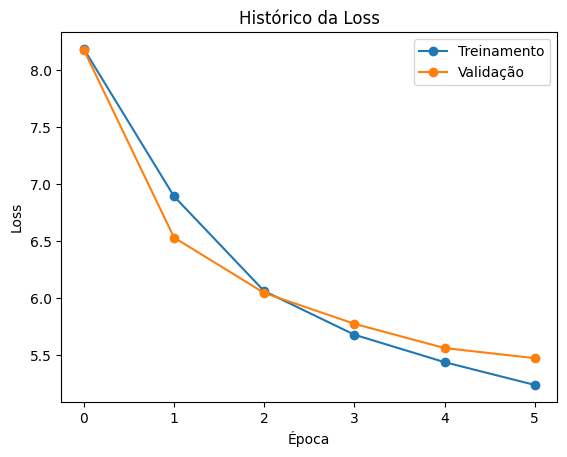

In [ ]:
plot_history(pretraining_hist, prop='loss', prop_name='Loss')

Podemos analisar o gráfico do histórico da *perplexidade*, em épocas, conforme o pré-treinamento ocorreu:

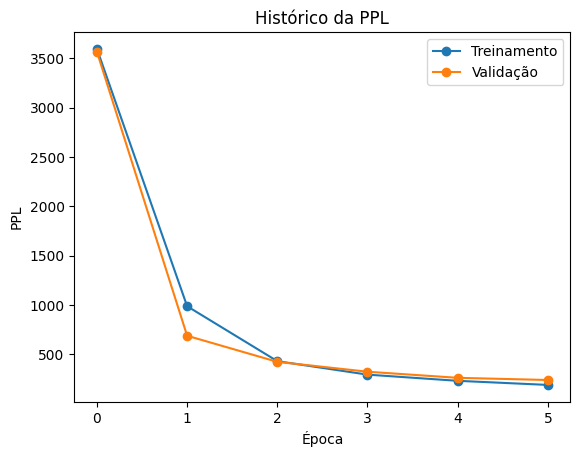

In [ ]:
plot_history(pretraining_hist, prop='ppl', prop_name='PPL')

## Fine-tuning com LoRA

Habilitamos o LoRA e avaliamos o número de parâmetros treináveis, verificando se o número de parâmetros treinados é menor:

In [ ]:
model.freeze_n_enable_lora(freeze_base=True, enable_lora=True)

In [ ]:
print_number_of_parameters(model)

Número de parâmetros: 			 2,037,112
Número de parâmetros treináveis: 	 62,336


Realizamos o ajuste-fino com LoRA,
 também chamando a função `train` implementada anteriormente, porém desta vez após congelar os parâmetros base e descongelar os parâmetros do LoRA:

In [ ]:
model, lora_training_hist = train(
    model,
    train_data,
    val_data,
    batch_size,
    warmup_ratio,
    lora_epochs,
    lr/5,
    betas,
    eps,
    weight_decay,
)

Utilizando o device cuda:0 para realizar o treinamento.

Avaliação no conjunto de treinamento:
-------------------------------------
Loss:	5.1230
PPL:	167.8401
Tempo:	1.16 sec

Avaliação no conjunto de validação:
-----------------------------------
Loss:	5.4734
PPL:	238.2685
Tempo:	0.12 sec

   Treinamento   
-----------------
Época [01/10],             Train Loss: 5.1634,             Train PPL: 174.7581,             Val Loss: 5.4614,             Val PPL: 235.4254,             Tempo: 3.91 sec
Época [02/10],             Train Loss: 5.1543,             Train PPL: 173.1789,             Val Loss: 5.4608,             Val PPL: 235.2757,             Tempo: 3.35 sec
Época [03/10],             Train Loss: 5.1496,             Train PPL: 172.3630,             Val Loss: 5.4249,             Val PPL: 226.9779,             Tempo: 3.31 sec
Época [04/10],             Train Loss: 5.1281,             Train PPL: 168.6922,             Val Loss: 5.3789,             Val PPL: 216.7731,             Tempo: 3.39

Podemos analisar o gráfico do histórico da *loss*, em épocas, conforme o fine-tuning com LoRA ocorreu:

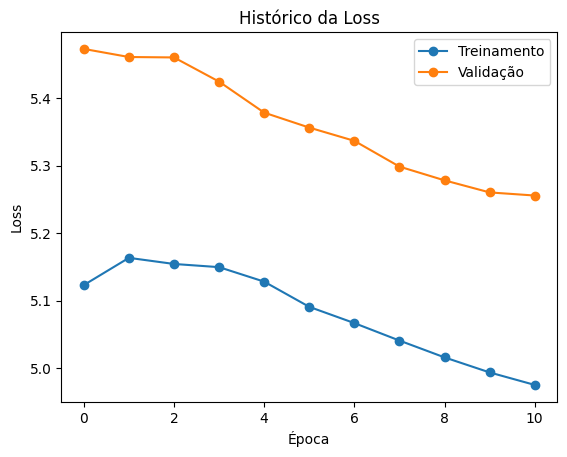

In [ ]:
plot_history(lora_training_hist, prop='loss', prop_name='Loss')

Podemos analisar o gráfico do histórico da *perplexidade*, em épocas, conforme o fine-tuning com LoRA ocorreu:

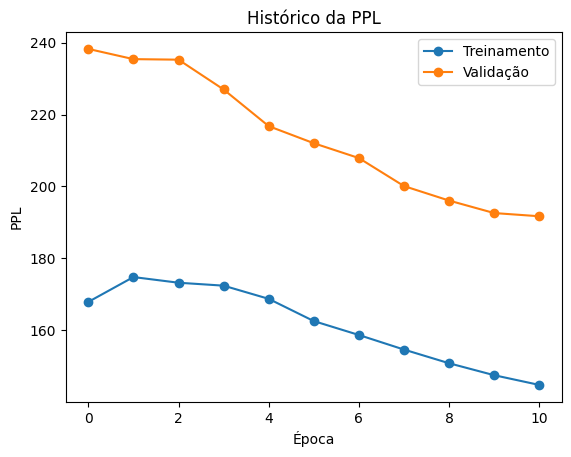

In [ ]:
plot_history(lora_training_hist, prop='ppl', prop_name='PPL')

## Comparação de tempo de treinamento: Pré-treino vs LoRA

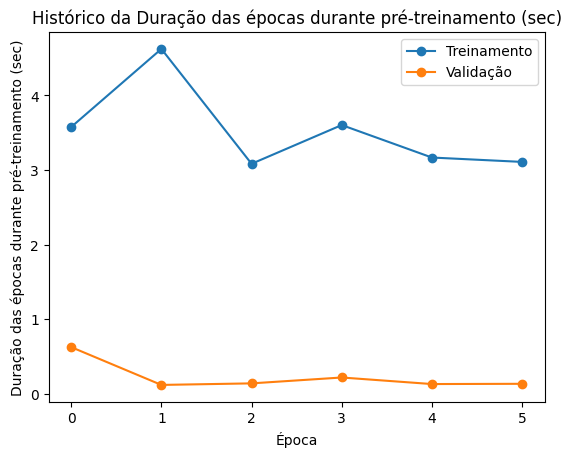

In [ ]:
plot_history(pretraining_hist, prop='epoch_duration', prop_name='Duração das épocas durante pré-treinamento (sec)')

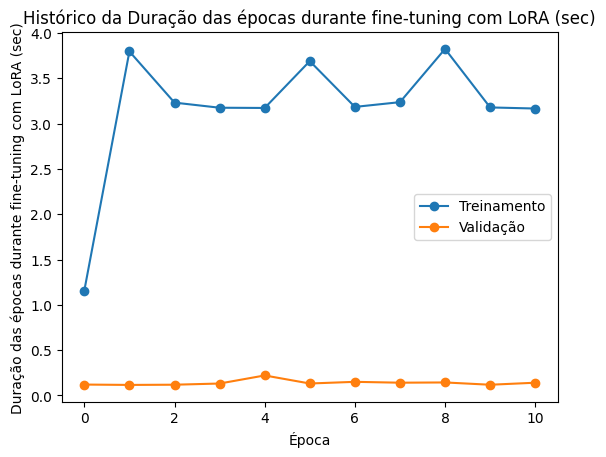

In [ ]:
plot_history(lora_training_hist, prop='epoch_duration', prop_name='Duração das épocas durante fine-tuning com LoRA (sec)')

In [ ]:
pretraining_val_durations = pretraining_hist['val_epoch_duration']
pretraining_train_durations = pretraining_hist['train_epoch_duration']

pretraining_mean_train_duration = sum(pretraining_train_durations)/len(pretraining_train_durations)
pretraining_mean_val_duration = sum(pretraining_val_durations)/len(pretraining_val_durations)

print(f'Duração do Pré-Treino:')
print(f'\tLaço de treinamento: \t {pretraining_mean_train_duration:.2f} sec')
print(f'\tLaço de validação: \t {pretraining_mean_val_duration:.2f} sec')

Duração do Pré-Treino:
	Laço de treinamento: 	 3.53 sec
	Laço de validação: 	 0.23 sec


In [ ]:
lora_val_durations = lora_training_hist['val_epoch_duration']
lora_train_durations = lora_training_hist['train_epoch_duration']

lora_mean_train_duration = sum(lora_train_durations)/len(lora_train_durations)
lora_mean_val_duration = sum(lora_val_durations)/len(lora_val_durations)

print(f'Duração do Fine-tuning com LoRA:')
print(f'\tLaço de treinamento: \t {lora_mean_train_duration:.2f} sec')
print(f'\tLaço de validação: \t {lora_mean_val_duration:.2f} sec')

Duração do Fine-tuning com LoRA:
	Laço de treinamento: 	 3.16 sec
	Laço de validação: 	 0.14 sec


# Avaliação

Faz o merge dos parâmetros treinados com LoRA no modelo e desabilita o LoRA:

Avalia o modelo no conjunto de teste:

In [ ]:
# Cria o DataLoader do conjunto de teste
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Avalia modelo treinado nos dados de teste
loss, ppl, eval_duration = eval_model_on_data(model, test_loader, device)

print_eval_metrics('teste', loss, ppl, eval_duration)

Avaliação no conjunto de teste:
-------------------------------
Loss:	5.2930
PPL:	198.9398
Tempo:	0.14 sec



# Síntese de texto

Para síntese do texto, foram criadas duas funções:

- `generate_next_token`: Gera o próximo `token` a partir de um contexto. Esse método não aceita contextos que possuam `tokens` fora do vocabulário;

- `generate_text`: Gera a continuação de um texto passado, interrompendo a geração caso o modelo gere o `token` `<EOS>` (*end-of-sentence*) ou o texto continuado ultrapasse de um número máximo de `tokens` `max_length`. Este método não aceita que seja passado um texto a ser continuado com `tokens` fora do vocabulário ou com uma quantidade de `tokens` menor do que o `context_size`.

In [ ]:
@torch.no_grad()
def generate_next_token(model, context, device, use_multinomial=False):
    # Verifica se o contexto é válido
    assert unknown_token_id not in context, f'Contexto "{text}" possui um token não que não está no vocabulário! Contexto codificado: {" ".join(str(x) for x in context)}'

    # Faz a predicao
    input = torch.LongTensor(context).to(device)
    output = model(input)

    # Remove dimensao do batch
    output = output.squeeze(dim=0)

    # Armazena as probabilidades do último token
    probs = F.softmax(output, dim=-1)

    # Escolhe o próximo token considerando a flag use_multinomial
    if use_multinomial == True:
        next_token = torch.multinomial(probs, num_samples=1).item()
    else:
        next_token = probs.argmax().item()

    return next_token


In [ ]:
@torch.no_grad()
def generate_text(model, text, max_length, device, use_multinomial=True, verbose=False):
    # Codifica sequência e verifica se possui tamanho válido
    encoded_text = encode_sentence(text, should_tokenize=True)
    assert len(encoded_text) >= context_size, f'Texto "{text}" possui tamanho menor do que o context_size = {context_size}. Tamanho do texto: {len(encoded_text)}.'

    # Configura modelo para avaliação
    model = model.to(device)
    model.eval()

    # Inicia com o token <SOS> (start of sentence)
    next_token = sos_token_id

    # Gera novos tokens até chegar ao max_length or gerar <EOS> (end of sentence)
    while len(encoded_text) < max_length and not next_token == eos_token_id:
        # Preve o próximo token
        context = encoded_text[-context_size:]
        next_token = generate_next_token(model, context, device, use_multinomial)

        # Se não for o token <EOS>, adiciona ao texto gerado
        if not next_token == eos_token_id:
            encoded_text.append(next_token)
            if verbose:
                print(f'Texto predito:\t{decode_sentence(encoded_text)}')

    if verbose:
        if next_token == eos_token_id:
            print(f'O texto foi finalizado porque o modelo gerou <EOS>.')
        else:
            print(f'O texto foi finalizado porque chegou ao contexto de tamanho máximo.')

    return decode_sentence(encoded_text)

Exemplos de síntese/geração de texto a partir de um contexto inicial:

In [ ]:
text = "Foi assim que a nossa amiga, pouco a pouco, "

In [ ]:
generate_text(model, text, max_length=20, device=device, use_multinomial=True, verbose=True)

Texto predito:	foi assim que a nossa amiga , pouco a pouco , a
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos .
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella para
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella para www
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella para www .
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella para www . in
Texto predito:	foi assim que a nossa amiga , pouco a pouco , a ambos . ella para www . in the
O texto foi finalizado porque chegou ao contexto de tamanho máximo.


'foi assim que a nossa amiga , pouco a pouco , a ambos . ella para www . in the'

In [ ]:
gen_text = generate_text(model, text, max_length=20, device=device, use_multinomial=True, verbose=True)
print(f'O texto gerado utilizando o multinomial foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem comprehendia
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem comprehendia ,
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem comprehendia , seus
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem comprehendia , seus alpendre
O texto foi finalizado porque chegou ao contexto de tamanho máximo.
O texto gerado utilizando o multinomial foi:
	foi assim que a nossa amiga , pouco a pouco , que e tinha volunteers quem c

In [ ]:
gen_text = generate_text(model, text, max_length=20, device=device, use_multinomial=False, verbose=True)
print(f'O texto gerado utilizando o argmax foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que o que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que o que o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que o que o que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o que o que o que o que o
O texto foi finalizado porque chegou ao contexto de tamanho máximo.
O texto gerado utilizando o argmax foi:
	foi assim que a nossa amiga , pouco a pouco , o que o que o que o que o


In [ ]:
gen_text = generate_text(model, text, max_length=80, device=device, use_multinomial=True, verbose=True)
print(f'O texto gerado utilizando o multinomial foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , ,
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of electronic
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of electronic project
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of electronic project gutenberg
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of electronic project gutenberg c
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio enchia of electronic project gutenberg c voltado
Texto predito:	foi assim que a nossa amiga , pouco a pouco , , e conseguio e

É possível notar que o modelo foi capaz de gerar textos muito mais coerentes, dentro do possível, se comparado aos modelos anteriores.

Porém, é possível notar que, apesar de ser treinado com `tokens` `<EOS>` nas amostras dos dados de treinamento, o modelo não gerou esse `token` nos exemplos sintetizados. Isso pode ter ocorrido devido ao fato de que poucos desses `tokens` ocorriam no conjunto de dados, já que só foram inseridos ao fim de cada parágrafos.